In [ ]:
import copy
import math

import numpy as np
import urllib
import cv2
import matplotlib.pyplot as plt

from torchvision import utils
from matplotlib import gridspec
plt.rcParams["figure.figsize"] = (10,10)

from hmax_models.hmax import *

%matplotlib inline

# Setting up

## Helper functions 

In [ ]:
def visTensor(tensor, ax, ch=0, allkernels=False, nrow=8, padding=1,title='',size=15): 
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    #plt.figure( figsize=(size,size) )
    ax.imshow(grid.numpy().transpose((1, 2, 0)))
    ax.set_title(title)
    ax.axis('off')
    #ax.ioff()
    
def visualize_s1_cells(model):
    row =-1 
    #fig, axs = plt.subplots(16,)
    fig = plt.figure(figsize=(20,30))
    gs = gridspec.GridSpec(16,1, height_ratios=[a/7. for a in range(7,39,2)])
    for scale in model.s1.l_sizes:
        row+=1
        s1_cell = getattr(model.s1, f's_{scale}')
        gabor_filter = s1_cell.weight.data.clone()
        string = 's1_%d'%gabor_filter.shape[-1]
        visTensor(gabor_filter,plt.subplot(gs[row]), ch=0, allkernels=False,nrow=4,title= string,size=gabor_filter.shape[-1])
    plt.axis('off')
    plt.ioff()
    plt.tight_layout()
    plt.savefig('Simple_Cells_visualziation.pdf')
    plt.show()
    
def visualize_s1_cells_image(model,image):
    row =-1 
    #fig, axs = plt.subplots(16,)
    fig = plt.figure(figsize=(20,30))
    gs = gridspec.GridSpec(16,1, height_ratios=[a/7. for a in range(7,39,2)])
    for s1_cell in model.s1:
        row+=1
        #s_cell = getattr(model,string)
        gabor_filter = s_cell.weight.data.clone()
        string = 's1_%d'%gabor_filter.shape[-1]
        visTensor(gabor_filter,plt.subplot(gs[row]), ch=0, allkernels=False,nrow=4,title= string,size=gabor_filter.shape[-1])
    plt.axis('off')
    plt.ioff()
    plt.tight_layout()
    plt.savefig('Simple_Cells_visualziation.pdf')
    plt.show()

In [ ]:
# Create an image with a gabor patch

def make_gabor_image(ori=0, scale=0, shift_h=0, shift_v=0, show_image = False):
    """
    ori: 0, 1, 2, or 3 indicating which of the 4 orientations used
    scale: index of the scale to use
    shift_h: how many pixels to shift patch horizontally
    shift_v: # how many pixels to shift patch vertically
    show_image: whether or not to show the image
    """
    image = np.zeros((224,224,3))
    gabor = model.s1.s1_7.weight[ori, :, :, :].detach().numpy().transpose(1, 2, 0)
    print(gabor.shape)

    offset_h = math.ceil((image.shape[0]-gabor.shape[0])/2)
    offset_w = math.ceil((image.shape[1]-gabor.shape[1])/2)

    image[offset_h + shift_v:offset_h+gabor.shape[0] + shift_v,
          offset_w + shift_h:offset_w+gabor.shape[1] + shift_h, :] = gabor # place gabor in the centre
    image = (image - image.min()) / (image.max() - image.min()) # normalize (min-max)
    
    if show_image:
        plt.imshow(image)
    
    return image

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

## Define model

In [ ]:
model = HMAX()
model.s1.s_7

Conv2d(3, 4, kernel_size=(7, 7), stride=(1, 1), padding=valid)

# Visualizations

## S1 filters 

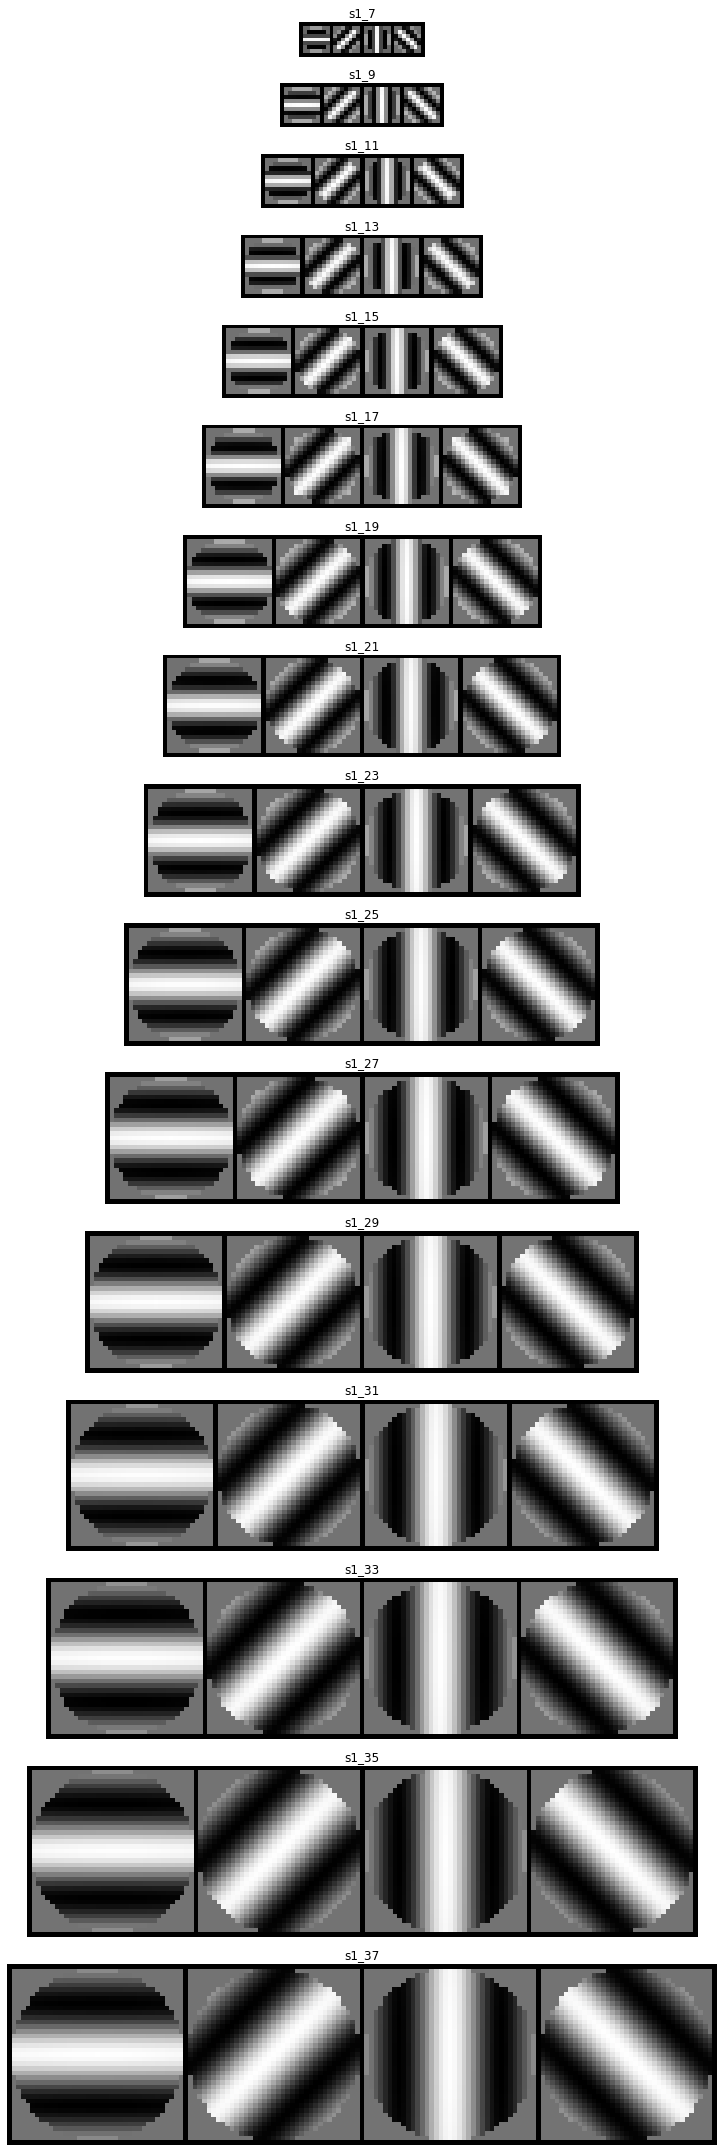

In [ ]:
visualize_s1_cells(model)

## Padding

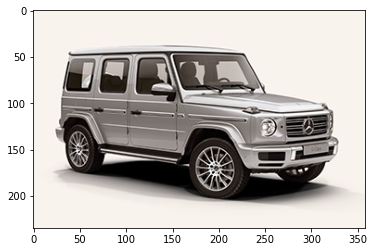

In [ ]:
with urllib.request.urlopen("https://cdn.euroncap.com/media/43129/mercedes-benz-g-class-359-235.png?mode=crop&width=359&height=235") as url:
    s = url.read()
    arr = np.asarray(bytearray(s), dtype=np.uint8)
    image = cv2.imdecode(arr, -1)
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)



plt.imshow(image)

img = torch.tensor([np.transpose(image,(2,0,1))])
img = img.float()
img = nn.functional.interpolate(img, size=(224,224))

valid True False
valid False False
valid False True
same False False


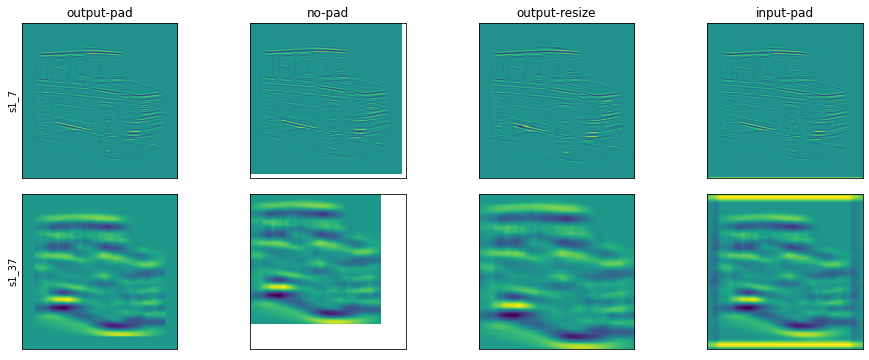

In [ ]:
padding_input_flags = ['valid', 'valid', 'valid','same']
padding_output_flags = [True, False, False, False]
resize_output_flags = [False, False, True, False]

gabor_idxs = [0,-1] # indices of scale to visualize

fig, axs = plt.subplots(nrows=len(gabor_idxs), ncols=len(padding_input_flags), gridspec_kw = {'wspace':0.1, 'hspace':0.1}, figsize=(16, 6), sharex=True, sharey=True)

row = 0
col = 0

for padding_input_flag, padding_output_flag, resize_output_flag in zip(padding_input_flags, padding_output_flags, resize_output_flags):
    print(padding_input_flag, padding_output_flag, resize_output_flag)
    if row == 0:
        title = []
        if padding_input_flag == 'same':
            title.append('input-pad')
        if padding_output_flag:
            title.append('output-pad')
        if resize_output_flag:
            title.append('output-resize')
        if len(title) == 0:
            title.append('no-pad')
        title = ';'.join(title)
        axs[row, col].set_title(title)
    
    for gabor_idx in gabor_idxs:
            s1_cell = copy.deepcopy(getattr(model.s1,  f's_{model.s1.l_sizes[gabor_idx]}'))
            s1_cell.padding = padding_input_flag
            kernel_size = s1_cell.weight.shape[-1]
            s1_cell_label = 's1_' + str(kernel_size)           
            
            output = s1_cell(img)
            
            if resize_output_flag:
                output = nn.functional.interpolate(output, img.shape[2:4])
            
            if padding_output_flag:
                pad = (int((img.shape[3] - output.shape[3]) / 2),
                       int((img.shape[3] - output.shape[3]) / 2),
                       int((img.shape[2] - output.shape[2]) / 2),
                       int((img.shape[2] - output.shape[2]) / 2))
                output = nn.functional.pad(output, pad=pad)
            
            axs[row, col].imshow(output.detach().numpy().squeeze()[0])
            axs[row, col].get_yaxis().set_ticks([])
            axs[row, col].get_xaxis().set_ticks([]) 
            
            # Set row title
            if col == 0:
                axs[row, col].set_ylabel(s1_cell_label)
            row += 1
            
    row = 0
    col += 1       
    

## Feature maps

In [ ]:
model.s1.s_7.register_forward_hook(get_activation('s_7'))
model.c1.register_forward_hook(get_activation('c1'))

In [ ]:
show_diff_col = False

# Make images to compare
images = [make_gabor_image(ori=0, scale=0, shift_h=0, shift_v=0),
          make_gabor_image(ori=0, scale=1, shift_h=0, shift_v=0)]
images = np.stack(images, axis=0)
images = torch.tensor(np.transpose(images,(0,3,1,2)))
images = images.float()
images.shape

# Get their activations
output = model(images)

# What to plot 
ori = 0
layer = 'c1'

# Setting up plot
fmaps = activation[layer][:,ori, :, :, :]
nrows = fmaps.shape[3] + 1
ncols = fmaps.shape[0] 

if show_diff_col:
    assert (fmaps.shape[0] == 2)
    ncols += 1
    diff_maps = fmaps[0, :, :, :] - fmaps[1, :, :, :]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, gridspec_kw = {'wspace':0.001, 'hspace':0.1}, figsize=(ncols*3, nrows*3), sharex=True, sharey=True)

fig.subplots_adjust(left=0, bottom=0, right=1, top=1)

# Show input images
if not show_diff_col:
    for c in range(ncols):
        axs[0, c].imshow(images.numpy().transpose(0,2,3,1)[c])
else:
    axs[0, 0].imshow(images.numpy().transpose(0,2,3,1)[0])
    axs[0, 1].imshow(images.numpy().transpose(0,2,3,1)[1])

# Show feature maps (and diff maps if requested)
for r in range(1, nrows):
    if not show_diff_col:
        print(show_diff_col)
        for c in range(ncols):
            axs[r, c].imshow(fmaps[c, :, :, r-1], vmin = fmaps.min(), vmax=fmaps.max())
    else:
        axs[r, 0].imshow(fmaps[0, :, :, r-1], vmin = fmaps.min(), vmax=fmaps.max())
        axs[r, 1].imshow(fmaps[1, :, :, r-1], vmin = fmaps.min(), vmax=fmaps.max())
        axs[r, 2].imshow(diff_maps[:, :, r-1], vmin = diff_maps.min(), vmax=diff_maps.max())

# Disable ticks
for r in range(nrows):
    for c in range(ncols):       
        axs[r, c].get_yaxis().set_ticks([])
        axs[r, c].get_xaxis().set_ticks([])

fig.suptitle(layer + ' activations', y = 1.01)
fig.patch.set_facecolor('white')

AttributeError: 'S1' object has no attribute 's1_7'

In [ ]:
fmaps[1, :, :, 14].max()

tensor(31.6075)

In [ ]:
for ax, interp_method in zip(axs.flat, methods):
    ax.imshow(grid, interpolation=interp_method, cmap='viridis')
    ax.set_title(str(interp_method))
    
    
s1_7 = nn.Conv2d(3, n_ori, 7,padding='valid')
s1_7.weight = nn.Parameter(getattr(model,'s1_7').weight.data.clone(), requires_grad=trainable_filters)

s1_37 = nn.Conv2d(3, n_ori, 37,padding='valid' )
s1_37.weight = nn.Parameter(getattr(model,'s1_37').weight.data.clone(), requires_grad=trainable_filters)

x7 = s1_7(img)
x37 =s1_37(img)

In [ ]:
plt.imshow(x7.detach().numpy().squeeze()[0])

In [ ]:
plt.imshow(x37.detach().numpy().squeeze()[0])

In [ ]:
#def printnorm(self, input, output):
#    # input is a tuple of packed inputs
#    # output is a Tensor. output.data is the Tensor we are interested
#    print('Inside ' + self.__class__.__name__ + ' forward')
#    print('')
#    print('input: ', type(input))
#    print('input[0]: ', type(input[0]))
#    print('output: ', type(output))
#    print('')
#    print('input size:', input[0].size())
#    print('output size:', output.data.size())
#    print('output norm:', output.data.norm())
#
#model.c1.register_forward_hook(printnorm)
#
#out = model(img)

In [ ]:
#for i in range(7,39,2):
#        string = 's1_%d'%i
#        s_cell = getattr(model,string)
#        s_cell.register_forward_hook(get_activation(string))
        
#for string in ['c1', 'xa', 'xb', 'xc', 'xd', 'xe', 'xh']:
#    cell = getattr(model, string)
#    cell.register_forward_hook(get_activation(string))

In [ ]:
activation.keys()

In [ ]:
activation.keys()

In [ ]:
output = model(img)

In [ ]:
act1 = activation['s1_7'].squeeze()[0]
act2 = activation['s1_9'].squeeze()[0]

In [ ]:
c1.position_pool

In [ ]:
c1 = C1()
maxact = torch.max(act1,act2)
poolact = c1.position_pool(torch.unsqueeze(maxact,0))

In [ ]:
plt.imshow(poolact[0])

In [ ]:
act = activation['xa'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

In [ ]:
act = activation['xa'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

In [ ]:
act = activation['s1_11'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx]>10)

In [ ]:
activation.keys()